# Обработка сигналов в Python
# Применение Deep Complex U-net для улучшения определения пиков сердцебиения в PPG сигнале

# Подход

Будет использоваться подход описанный в статье:
https://openreview.net/pdf?id=SkeRTsAcYm

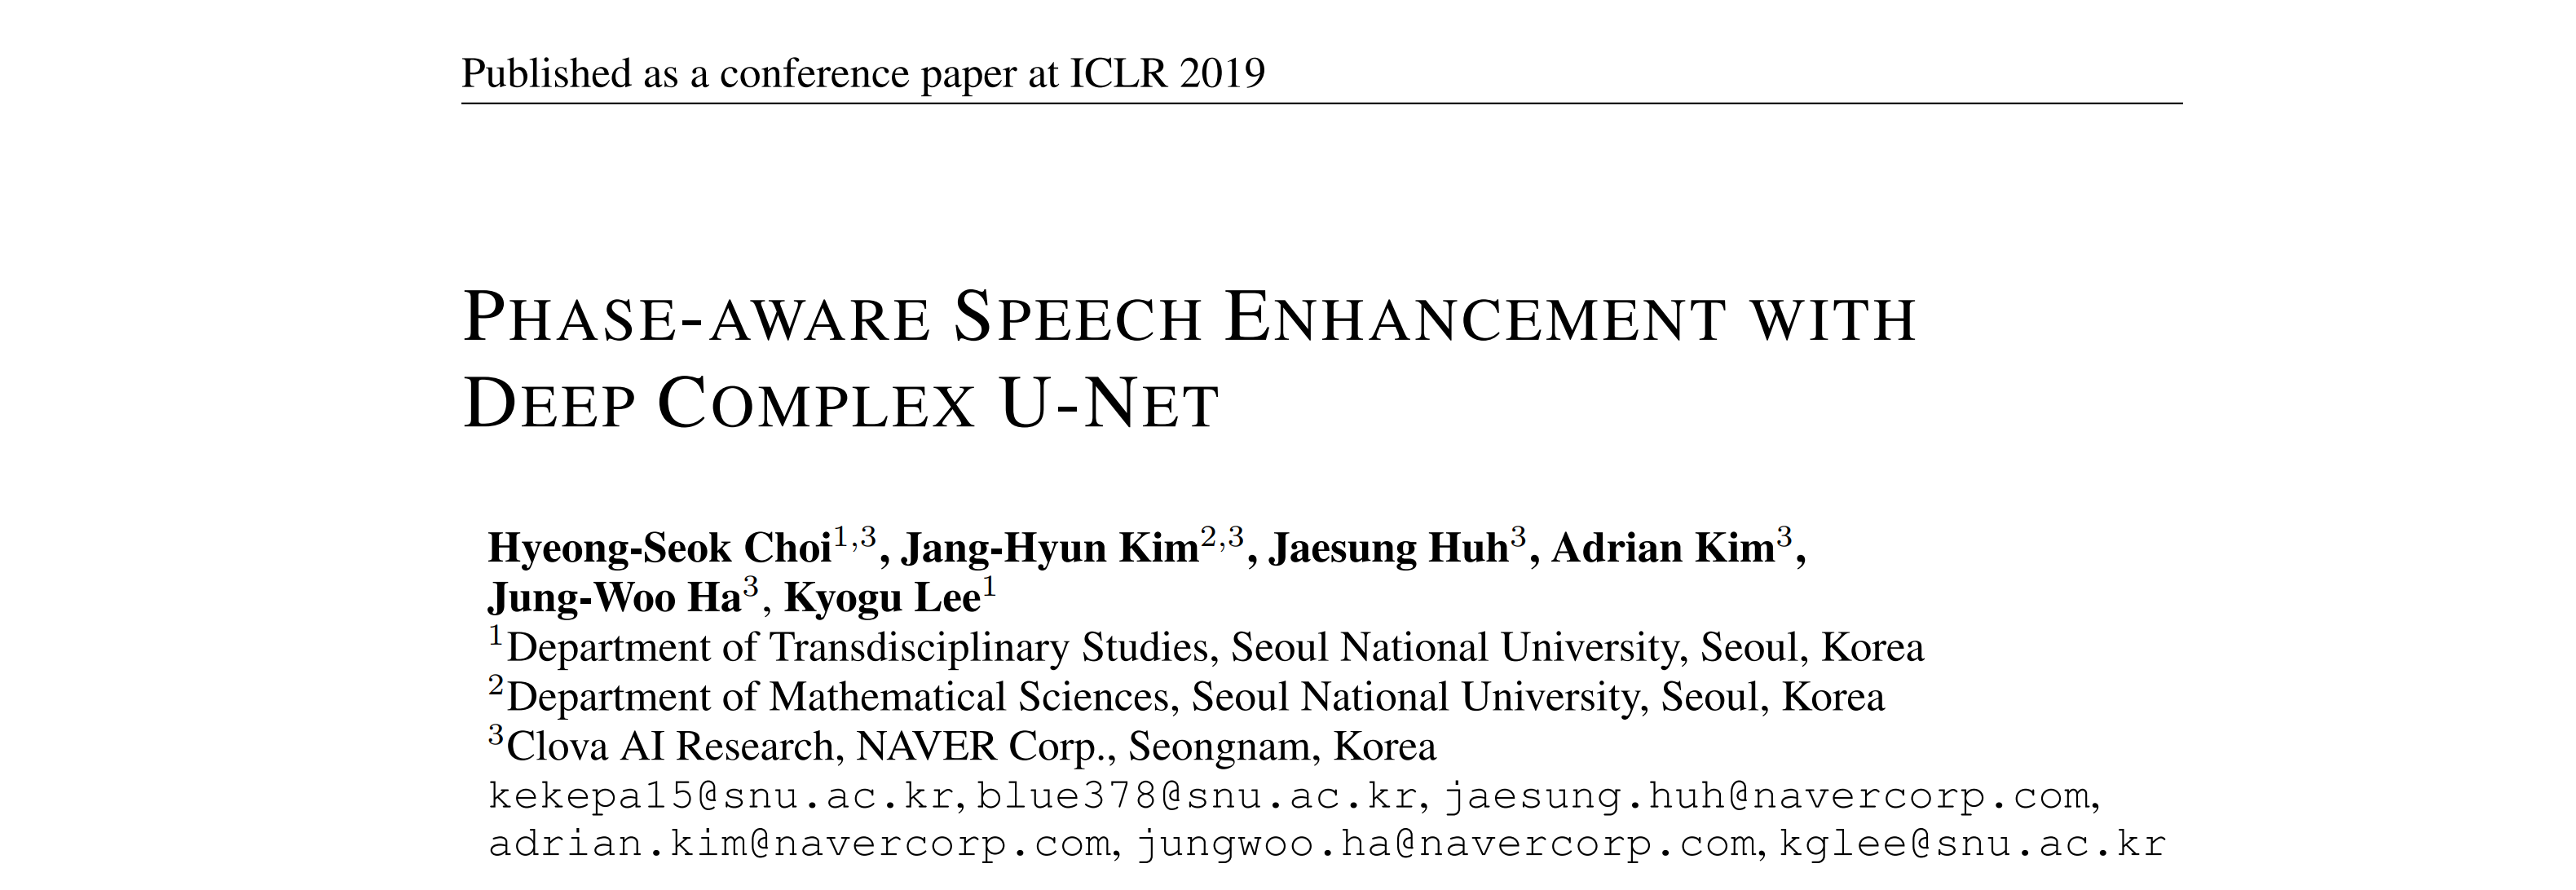

In [2]:
from IPython.display import Image
Image("./img/header_new.png", width=700)

В статье выше описана архитектура свёрточной нейронной сети для улучшения звука путём фильтрации шумов.

## Deep Complex U-Net (DCUnet)

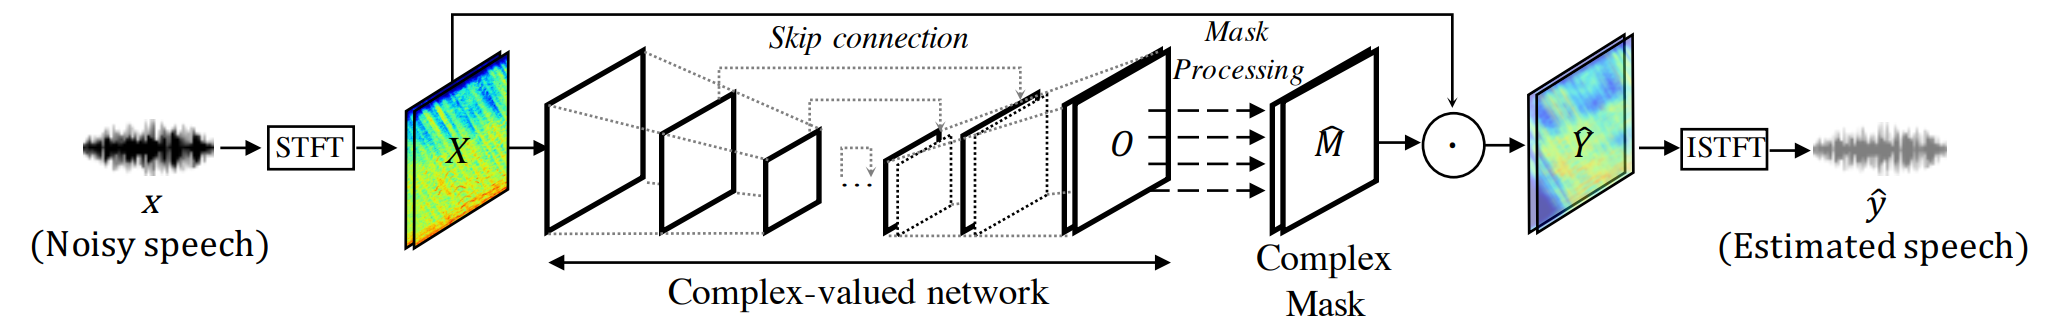

In [3]:
Image("./img/DCUnet_new2.png") 

Рисунок иллюстрирует схему данного подхода.

Мы же попробуем применить данную архитектуру к задаче фильтрации PPG сигнала.

## Complex Mask

В результате работы свёрточных слоёв мы получаем маску, которую затем перемножаем со спектрограммой зашумлённого сигнала, получая отфильтрованный сигнал.

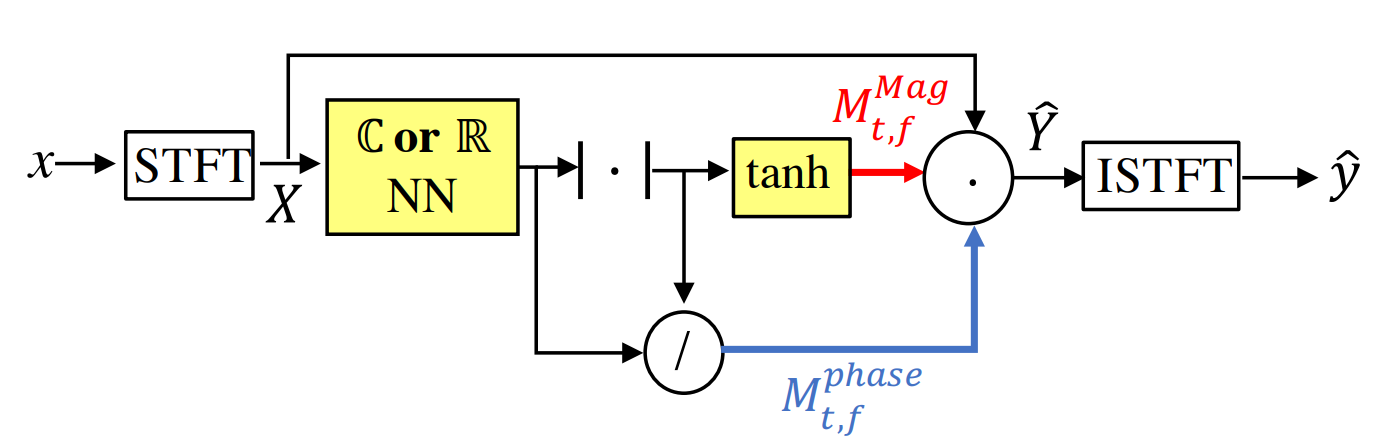

In [4]:
Image("./img/arch_new.png", width=500) 

# Complex-valued Convolution

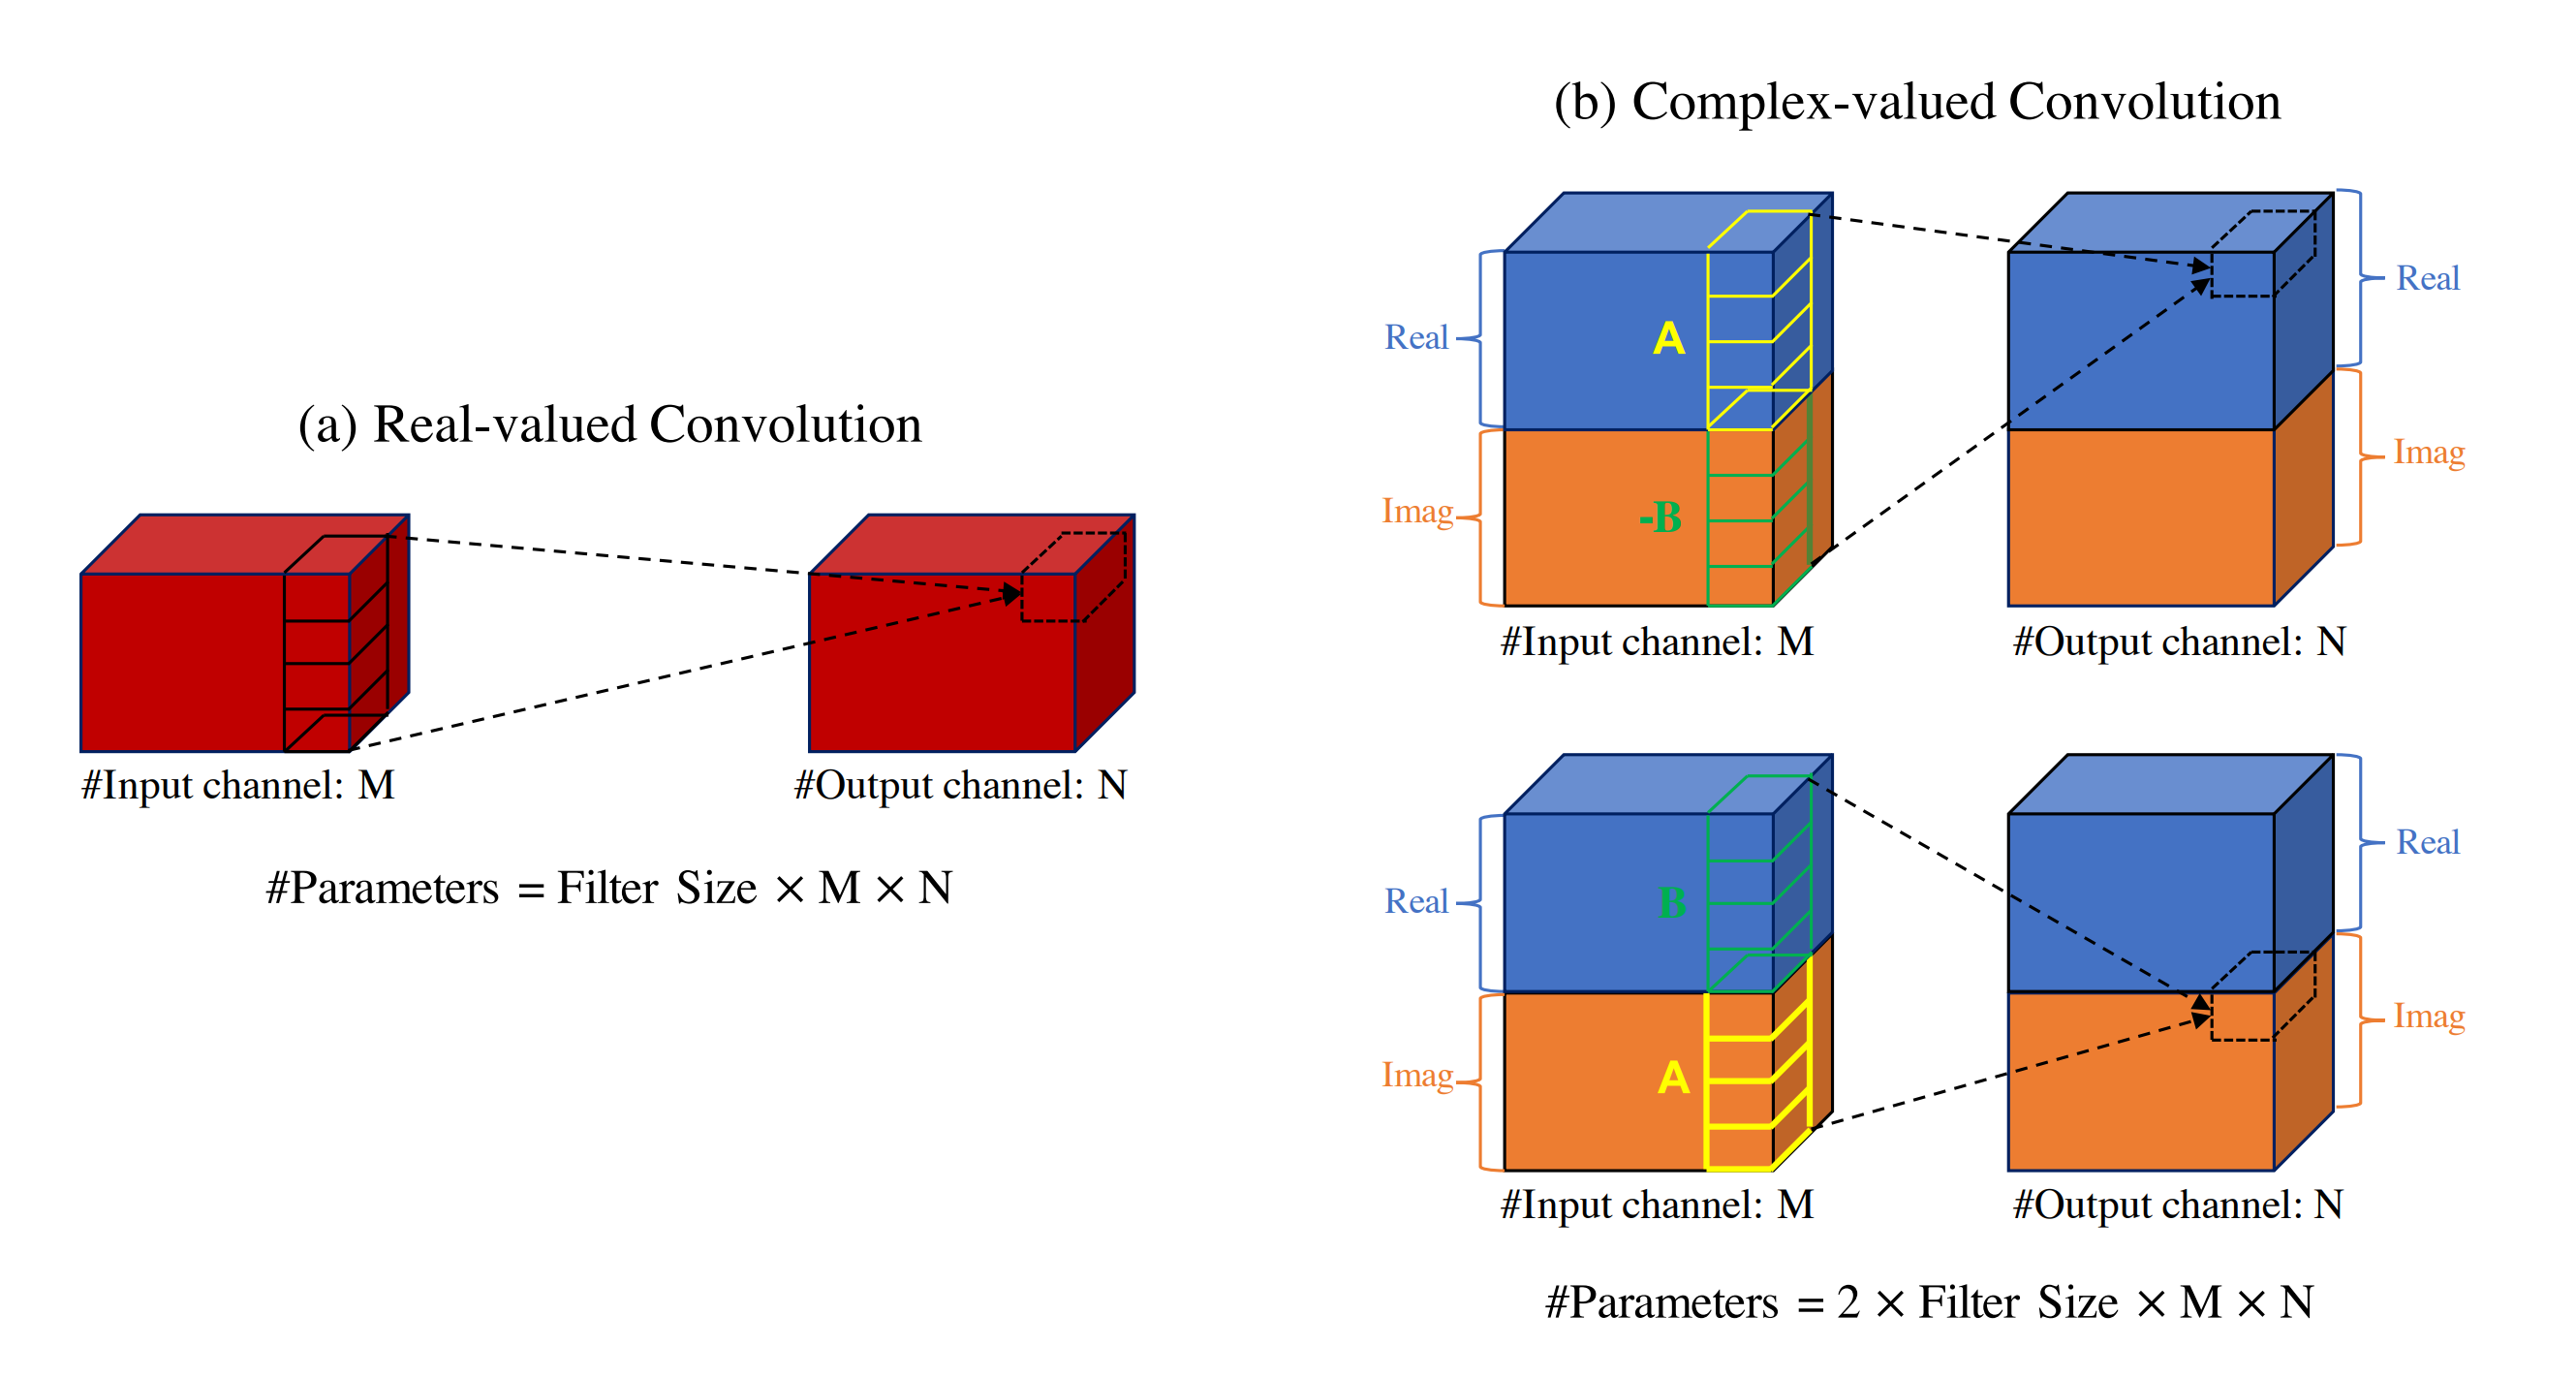

In [5]:
Image("./img/fig8.png", width=800)

## DCUnet-20

Будем использовать вариант архитектуры состоящий из 20-ти свёрточных слоёв.

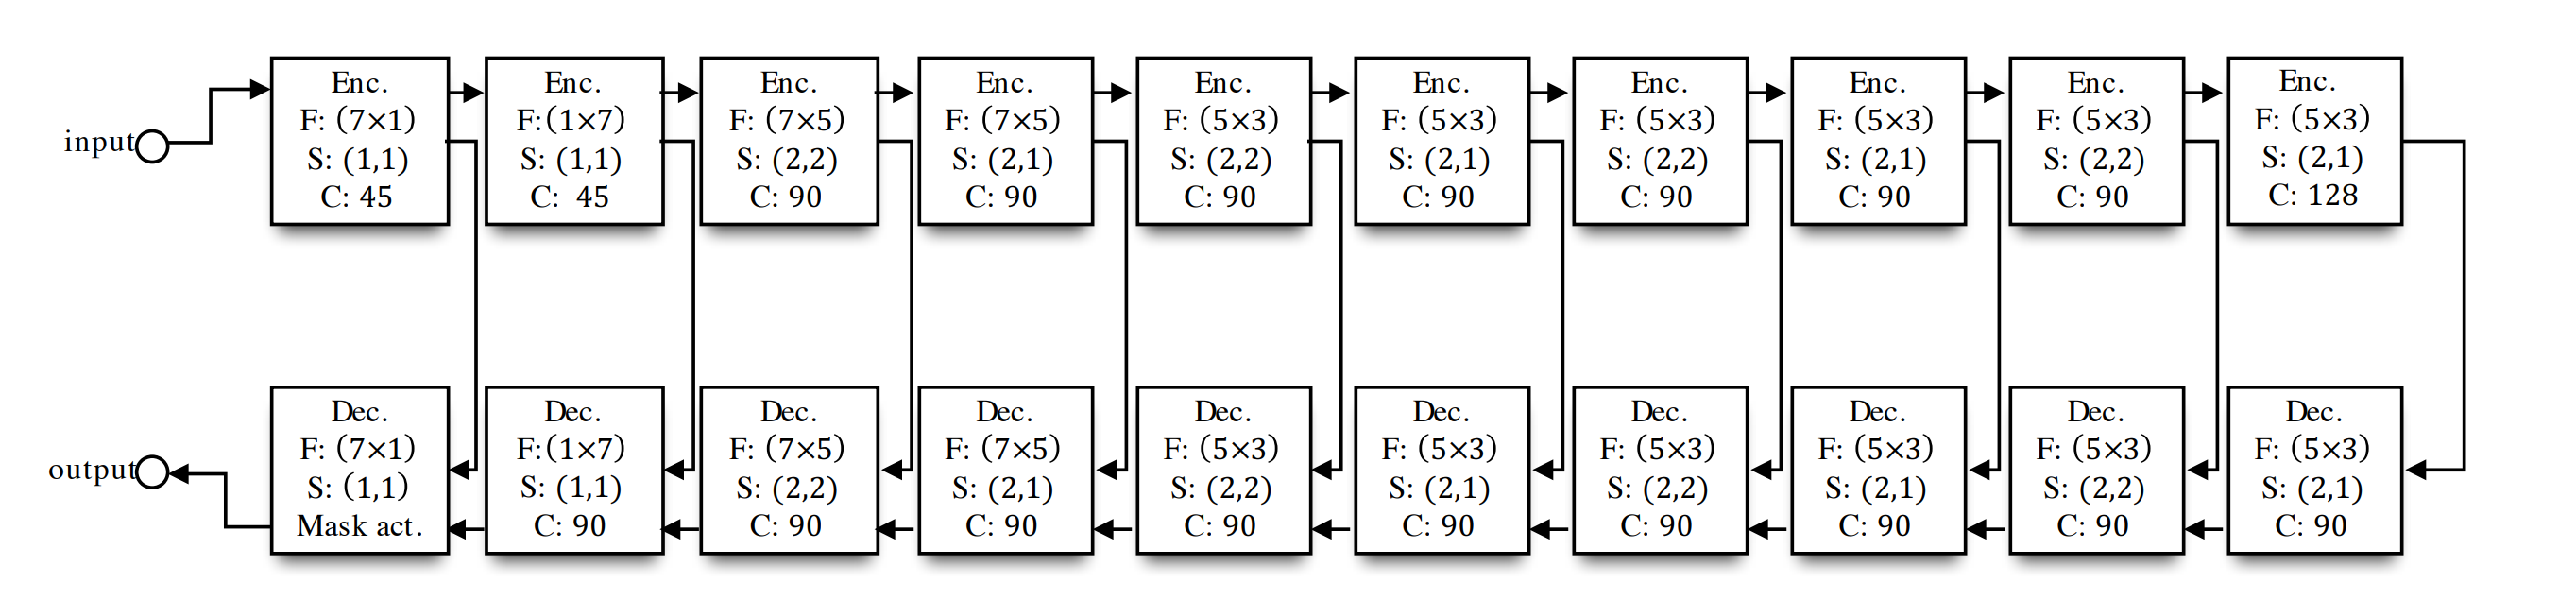

In [6]:
Image("./img/DCUnet20.png", width=800)

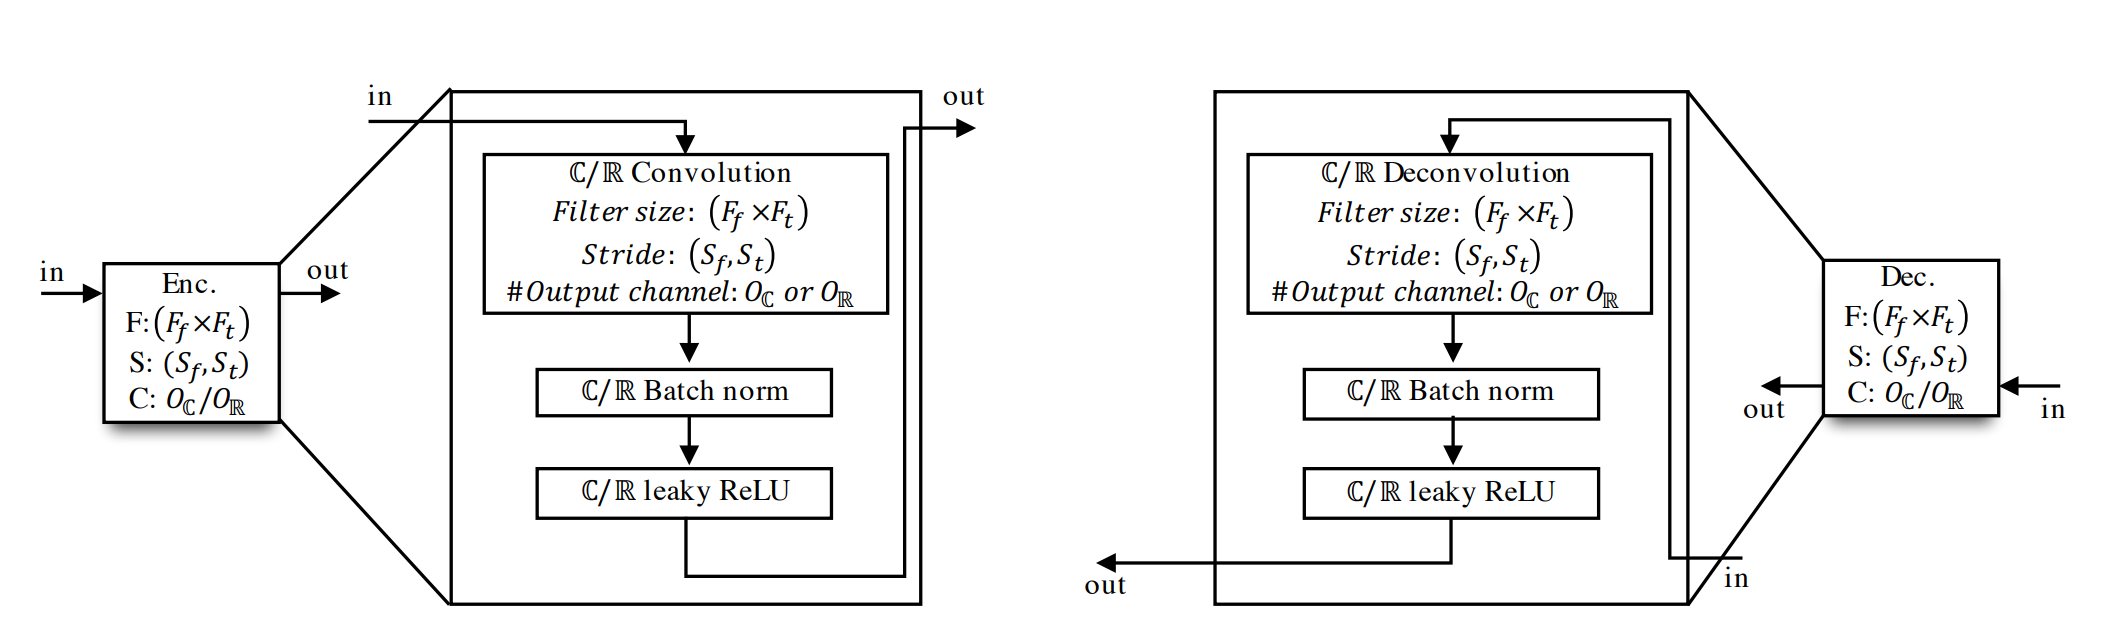

In [7]:
Image("./img/fig9.png", width=800)

# Loss function

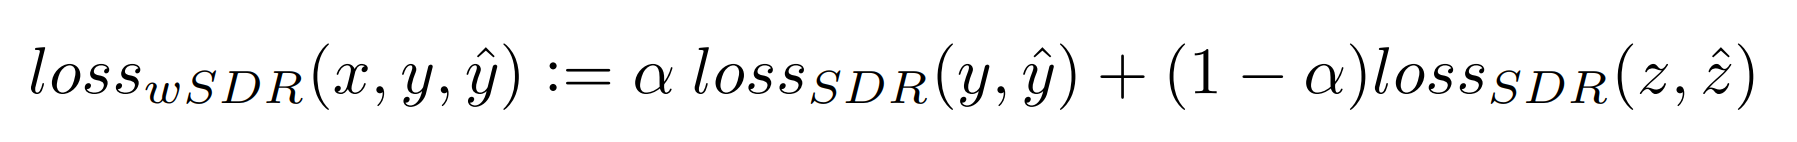

In [8]:
Image("./img/fig11.png", width=600)

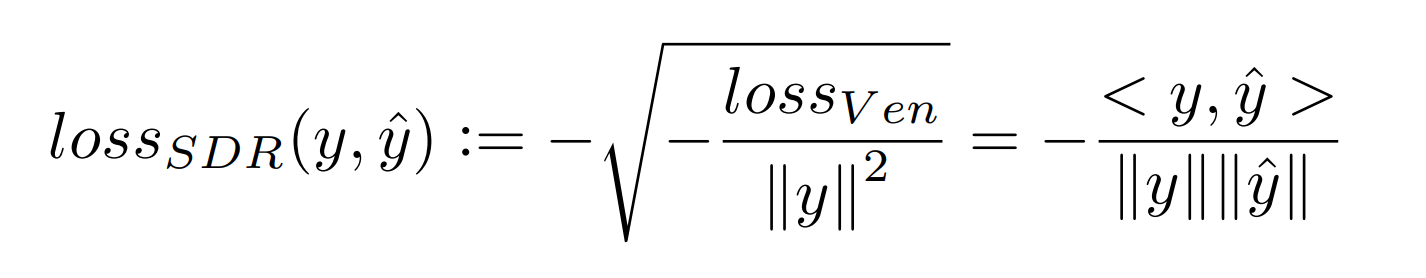

In [9]:
Image("./img/fig10.png", width=500)

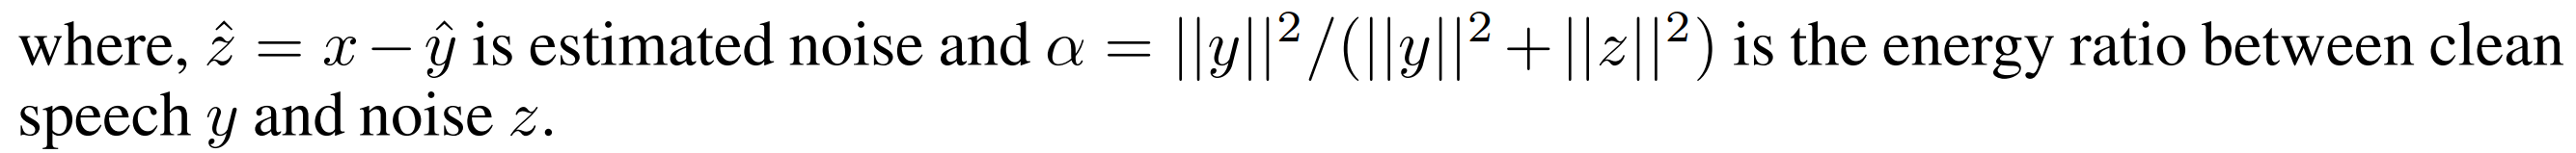

In [10]:
Image("./img/fig12.png", width=700)

## Импортируем библиотеки

In [11]:
import numpy as np 
import pandas as pd 
import pyarrow.csv
from scipy import signal, interpolate

from tqdm import tqdm, tqdm_notebook
from pathlib import Path
import glob
from functools import partial

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import gc

from IPython.display import Image
from matplotlib import colors, pyplot as plt
import seaborn as sns
import librosa.display
sns.set(style='darkgrid', palette="Set2", context='notebook')
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings("ignore")

In [12]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')
       
DEVICE = torch.device('cuda' if train_on_gpu else 'cpu')

Training on GPU.


In [13]:
#!nvidia-smi

In [14]:
TRAIN_PPG_DIR = Path('./signals/ppg_train')
TRAIN_ECG_DIR = Path('./signals/ecg_train')

TEST_PPG_DIR = Path('./signals/ppg_test')
TEST_ECG_DIR = Path('./signals/ecg_test')

In [15]:
train_ppg_files = sorted(list(TRAIN_PPG_DIR.rglob('*.csv')))
train_ecg_files = sorted(list(TRAIN_ECG_DIR.rglob('*.csv')))

test_ppg_files = sorted(list(TEST_PPG_DIR.rglob('*.csv')))
test_ecg_files = sorted(list(TEST_ECG_DIR.rglob('*.csv')))

In [16]:
SAMPLE_RATE = 30 * 1
N_FFT = 1600 // 1 * SAMPLE_RATE * 64 // 1000 
HOP_LENGTH = 1600 // 2 * SAMPLE_RATE * 16 // 1000 

# Датасет и даталоадер.

In [17]:
class SignalsDataset(Dataset):
    """
    Класс подготавливает PPG и ECG сигналы, а именно:
    - добавляет паддинг
    - применяет нормализацию PPG
    - применяет интерполяцию PPG
    - аппроксимирует ECG кусочно заданными синусоидами вместо пиков
    - PPG и ECG приводятся к torch тензорам
    - применяет оконное преобразование Фурье для подготовленных PPG и ECG сигналов
    Далее спектрограммы сигналов готовы к подаче в загрузчик данных
    """

    def __init__(self, ppg_files, ecg_files, n_fft, hop_length, interpolation=False, is_istft=True):
        super().__init__()
        # list of files
        self.ppg_files = sorted(ppg_files)
        self.ecg_files = sorted(ecg_files)
        
        # stft parameters
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.window = torch.hann_window(n_fft)

        self.len_ = len(self.ppg_files)
        
        # fixed len
        self.max_len = 175000 * 1
        
        #interpolation flag
        self.interpolation = interpolation
        
        #Short-time Fourier transform flag
        self.is_istft = is_istft

    
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        signal_df = pyarrow.csv.read_csv(file).to_pandas()
        return signal_df

    def z_normalization(self, ppg_signal):
        return (ppg_signal - np.mean(ppg_signal)) / np.std(ppg_signal)
        
    def _prepare_ppg_signal(self, ppg_df):
        ppg_signal = ppg_df['PPG_signal'].values
        timestamps = ppg_df['Timestamp'].values

        ppg_signal = self.z_normalization(ppg_signal)

        ts_start = timestamps[0]
        ts_finish = timestamps[-1]
     
        if self.interpolation:
            timestamps_interp = np.linspace(ts_start, ts_finish, int((ts_finish - ts_start) * SAMPLE_RATE))
            f = interpolate.interp1d(timestamps, ppg_signal,"cubic")
            ppg_signal = f(timestamps_interp)
        else:
            timestamps_interp = timestamps
        
        current_len = len(ppg_signal)
        
        output = np.zeros((1, self.max_len), dtype='float32')
        output[0, -current_len:] = ppg_signal[:self.max_len]
        output = torch.from_numpy(output)
        
        pad = HOP_LENGTH - self.max_len % HOP_LENGTH 
        padded_signal = torch.cat((torch.zeros(1,pad), output), 1)
        
        return timestamps_interp, padded_signal

    def _prepare_ecg_signal(self, ecg_df, timestamps_interp):
        gt_peaks = ecg_df['ECG_peaks'].values
        gt_signal = np.zeros_like(timestamps_interp)
        phase = np.arange(1, len(gt_peaks) + 1)
        cs = interpolate.CubicSpline(gt_peaks, phase)
        bound_mask = (timestamps_interp >= gt_peaks[0]) & (timestamps_interp <= gt_peaks[-1])
        gt_signal[bound_mask] = np.cos(cs(timestamps_interp[bound_mask]) * 2 * np.pi) * 0.5 + 0.5
        
        current_len = len(gt_signal)
        
        output = np.zeros((1, self.max_len), dtype='float32')
        output[0, -current_len:] = gt_signal[:self.max_len]
        output = torch.from_numpy(output)
        
        pad = HOP_LENGTH - self.max_len % HOP_LENGTH 
        padded_signal = torch.cat((torch.zeros(1,pad), output), 1)
        
        return padded_signal

    def __getitem__(self, index):
        # load
        x_ppg = self.load_sample(self.ppg_files[index])
        x_ecg = self.load_sample(self.ecg_files[index])
        
        
        # padding/normalization/interpolation
        timestamps_interp, x_ppg = self._prepare_ppg_signal(x_ppg)
        x_ecg = self._prepare_ecg_signal(x_ecg, timestamps_interp)
        
        # Short-time Fourier transform
        x_ppg_stft = torch.stft(input=x_ppg, n_fft=self.n_fft, 
                                  hop_length=self.hop_length, window=self.window, normalized=True, return_complex=False)
        x_ecg_stft = torch.stft(input=x_ecg, n_fft=self.n_fft, 
                                  hop_length=self.hop_length, window=self.window, normalized=True, return_complex=False)
        if self.is_istft:
            return x_ppg_stft, x_ecg_stft
        else:
            return x_ppg, x_ecg

In [17]:
test_dataset = SignalsDataset(test_ppg_files, test_ecg_files, N_FFT, HOP_LENGTH, interpolation=True, is_istft=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
ppg_n, ecg_c = next(iter(test_loader))

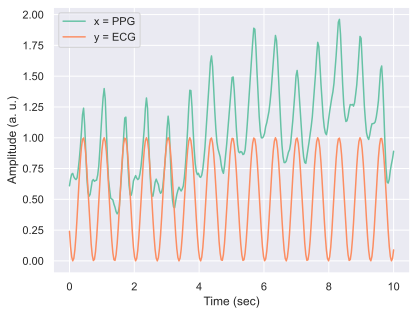

In [18]:
start = 25700
finish = 26000
plt.plot(np.linspace(0, 300 / SAMPLE_RATE, 300), -8+10*ppg_n[0][0][start:finish]);
plt.plot(np.linspace(0, 300 / SAMPLE_RATE, 300), ecg_c[0][0][start:finish]);
plt.legend(['x = PPG', 'y = ECG'])
plt.xlabel('Time (sec)');
plt.ylabel('Amplitude (a. u.)');

Т.о. в нашей постановке задачи, мы подаём на вход нейронной сети PPG сигнал, а на выходе сравниваем результат с ECG сигналом, полученный путём интерполяциии кусочнозаданной синусоидальной функцией между пиками.

# Задаём классы слоёв нейронной сети.

In [19]:
class CConv2d(nn.Module):
    """
    Класс комплексного свёрточного слоя
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        
        self.real_conv = nn.Conv2d(in_channels=self.in_channels, 
                                   out_channels=self.out_channels, 
                                   kernel_size=self.kernel_size, 
                                   padding=self.padding, 
                                   stride=self.stride)
        
        self.im_conv = nn.Conv2d(in_channels=self.in_channels, 
                                 out_channels=self.out_channels, 
                                 kernel_size=self.kernel_size, 
                                 padding=self.padding, 
                                 stride=self.stride)
        
        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_conv.weight)
        nn.init.xavier_uniform_(self.im_conv.weight)
        
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        c_real = self.real_conv(x_real) - self.im_conv(x_im)
        c_im = self.im_conv(x_real) + self.real_conv(x_im)
        
        output = torch.stack([c_real, c_im], dim=-1)
        return output

In [20]:
class CConvTranspose2d(nn.Module):
    """
    Класс комплексного transpose конволюционного слоя
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding=0, padding=0):
        super().__init__()
        
        self.in_channels = in_channels

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.output_padding = output_padding
        self.padding = padding
        self.stride = stride
        
        self.real_convt = nn.ConvTranspose2d(in_channels=self.in_channels, 
                                            out_channels=self.out_channels, 
                                            kernel_size=self.kernel_size, 
                                            output_padding=self.output_padding,
                                            padding=self.padding,
                                            stride=self.stride)
        
        self.im_convt = nn.ConvTranspose2d(in_channels=self.in_channels, 
                                            out_channels=self.out_channels, 
                                            kernel_size=self.kernel_size, 
                                            output_padding=self.output_padding, 
                                            padding=self.padding,
                                            stride=self.stride)
        
        
        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_convt.weight)
        nn.init.xavier_uniform_(self.im_convt.weight)
        
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        ct_real = self.real_convt(x_real) - self.im_convt(x_im)
        ct_im = self.im_convt(x_real) + self.real_convt(x_im)
        
        output = torch.stack([ct_real, ct_im], dim=-1)
        return output

In [21]:
class CBatchNorm2d(nn.Module):
    """
    Класс комплексной батч нормализации
    """
    def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True):
        super().__init__()
        
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        
        self.real_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                      affine=self.affine, track_running_stats=self.track_running_stats)
        self.im_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                    affine=self.affine, track_running_stats=self.track_running_stats) 
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        n_real = self.real_b(x_real)
        n_im = self.im_b(x_im)  
        
        output = torch.stack([n_real, n_im], dim=-1)
        return output

In [22]:
class Encoder(nn.Module):
    """
    Класс кодировщика (upsample блок)
    """
    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45, padding=(0,0)):
        super().__init__()
        
        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = padding

        self.cconv = CConv2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, padding=self.padding)
        
        self.cbn = CBatchNorm2d(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconv(x)
        normed = self.cbn(conved)
        acted = self.leaky_relu(normed)
        
        return acted

In [23]:
class Decoder(nn.Module):
    """
    Класс декодировщика (downsample блок)
    """
    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45,
                 output_padding=(0,0), padding=(0,0), last_layer=False):
        super().__init__()
        
        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_padding = output_padding
        self.padding = padding
        
        self.last_layer = last_layer
        
        self.cconvt = CConvTranspose2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, output_padding=self.output_padding, padding=self.padding)
        
        self.cbn = CBatchNorm2d(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconvt(x)
        
        if not self.last_layer:
            normed = self.cbn(conved)
            output = self.leaky_relu(normed)
        else:
            m_phase = conved / (torch.abs(conved) + 1e-8)
            m_mag = torch.tanh(torch.abs(conved))
            output = m_phase * m_mag
            
        return output

# Модель DCUnet-20

In [47]:
class DCUnet20(nn.Module):
    """
    Класс модели Deep Complex U-Net с 20-ю свёрточными слоями
    """
    def __init__(self, n_fft, hop_length):
        super().__init__()
        
        # for istft
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.window = torch.hann_window(n_fft).to(DEVICE)
        
        # downsampling/encoding
        self.downsample0 = Encoder(filter_size=(7,1), stride_size=(1,1), in_channels=1, out_channels=45)
        self.downsample1 = Encoder(filter_size=(1,7), stride_size=(1,1), in_channels=45, out_channels=45)
        self.downsample2 = Encoder(filter_size=(7,5), stride_size=(2,2), in_channels=45, out_channels=90)
        self.downsample3 = Encoder(filter_size=(7,5), stride_size=(2,1), in_channels=90, out_channels=90)
        self.downsample4 = Encoder(filter_size=(5,3), stride_size=(2,2), in_channels=90, out_channels=90)
        self.downsample5 = Encoder(filter_size=(5,3), stride_size=(2,2), in_channels=90, out_channels=90)
        self.downsample6 = Encoder(filter_size=(5,3), stride_size=(2,2), in_channels=90, out_channels=90)
        self.downsample7 = Encoder(filter_size=(5,3), stride_size=(2,1), in_channels=90, out_channels=90)
        self.downsample8 = Encoder(filter_size=(5,3), stride_size=(2,2), in_channels=90, out_channels=90)
        self.downsample9 = Encoder(filter_size=(5,3), stride_size=(2,1), in_channels=90, out_channels=128)
        
        # upsampling/decoding
        self.upsample0 = Decoder(filter_size=(5,3), stride_size=(2,1), in_channels=128, out_channels=90, output_padding=(1, 0))
        self.upsample1 = Decoder(filter_size=(5,3), stride_size=(2,2), in_channels=180, out_channels=90, output_padding=(1, 1))
        self.upsample2 = Decoder(filter_size=(5,3), stride_size=(2,1), in_channels=180, out_channels=90, output_padding=(1, 0))
        self.upsample3 = Decoder(filter_size=(5,3), stride_size=(2,2), in_channels=180, out_channels=90, output_padding=(1, 1))
        self.upsample4 = Decoder(filter_size=(5,3), stride_size=(2,2), in_channels=180, out_channels=90, output_padding=(1, 0))
        self.upsample5 = Decoder(filter_size=(5,3), stride_size=(2,2), in_channels=180, out_channels=90, output_padding=(0, 1))
        self.upsample6 = Decoder(filter_size=(7,5), stride_size=(2,1), in_channels=180, out_channels=90)
        self.upsample7 = Decoder(filter_size=(7,5), stride_size=(2,2), in_channels=180, out_channels=45)
        self.upsample8 = Decoder(filter_size=(1,7), stride_size=(1,1), in_channels=90, out_channels=45)
        self.upsample9 = Decoder(filter_size=(7,1), stride_size=(1,1), in_channels=90, out_channels=1, 
                                 output_padding=(0, 0), last_layer=True)
        
        
    def forward(self, x, is_istft=True):
        # downsampling/encoding
        d0 = self.downsample0(x)
        d1 = self.downsample1(d0)
        d2 = self.downsample2(d1)
        d3 = self.downsample3(d2)
        d4 = self.downsample4(d3)
        d5 = self.downsample5(d4)
        d6 = self.downsample6(d5)
        d7 = self.downsample7(d6) 
        d8 = self.downsample8(d7)
        d9 = self.downsample9(d8)

        
        # upsampling/decoding 
        u0 = self.upsample0(d9)
        # skip-connection
        c0 = torch.cat((u0, d8), dim=1)
        
        u1 = self.upsample1(c0)
        c1 = torch.cat((u1, d7), dim=1)
        
        u2 = self.upsample2(c1)
        c2 = torch.cat((u2, d6), dim=1)
        
        u3 = self.upsample3(c2)
        c3 = torch.cat((u3, d5), dim=1)
        
        u4 = self.upsample4(c3)
        c4 = torch.cat((u4, d4), dim=1)
        
        u5 = self.upsample5(c4)
        c5 = torch.cat((u5, d3), dim=1)
        
        u6 = self.upsample6(c5)
        c6 = torch.cat((u6, d2), dim=1)
        
        u7 = self.upsample7(c6)
        c7 = torch.cat((u7, d1), dim=1)
        
        u8 = self.upsample8(c7)
        c8 = torch.cat((u8, d0), dim=1)
        
        u9 = self.upsample9(c8)
        
        # u9 - the mask
        output = u9 * x
        if is_istft:
            output = torch.squeeze(output, 1)
            temp = output[:,:,:,0] + output[:,:,:,1] * 1j
            output = temp
            output = torch.istft(output, n_fft=self.n_fft, hop_length=self.hop_length, window=self.window, normalized=True, return_complex=False)
        return output

# Определение Loss функции

In [25]:
def wsdr_fn(x_, y_pred_, y_true_, eps=1e-8):
    """
    Loss функция
    """
    # to time-domain waveform
    y_true_ = torch.squeeze(y_true_, 1)
    temp = y_true_[:,:,:,0] + y_true_[:,:,:,1] * 1j
    y_true_ = temp
    x_ = torch.squeeze(x_, 1)
    temp = x_[:,:,:,0] + x_[:,:,:,1] * 1j
    x_ = temp
    y_true = torch.istft(y_true_, n_fft=N_FFT, hop_length=HOP_LENGTH, window = torch.hann_window(N_FFT).to(DEVICE), normalized=True, return_complex=False)
    x = torch.istft(x_, n_fft=N_FFT, hop_length=HOP_LENGTH, window = torch.hann_window(N_FFT).to(DEVICE), normalized=True, return_complex=False)

    y_pred = y_pred_.flatten(1)
    y_true = y_true.flatten(1)
    x = x.flatten(1)


    def sdr_fn(true, pred, eps=1e-8):
        num = torch.sum(true * pred, dim=1)
        den = torch.norm(true, p=2, dim=1) * torch.norm(pred, p=2, dim=1)
        return -(num / (den + eps))

    # true and estimated noise
    z_true = x - y_true
    z_pred = x - y_pred

    a = torch.sum(y_true**2, dim=1) / (torch.sum(y_true**2, dim=1) + torch.sum(z_true**2, dim=1) + eps)
    wSDR = a * sdr_fn(y_true, y_pred) + (1 - a) * sdr_fn(z_true, z_pred)
    return torch.mean(wSDR)

# Функция обучения

In [26]:
def train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    for noisy_x, clean_x in train_loader:

        noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)

        # zero  gradients
        net.zero_grad()

        # get the output from the model
        pred_x = net(noisy_x)

        # calculate loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item() 
        counter += 1

    train_ep_loss /= counter

    # clear cache
    gc.collect()
    torch.cuda.empty_cache()
    return train_ep_loss

# Функция валидации

In [27]:
def test_epoch(net, test_loader, loss_fn):
    net.eval()
    test_ep_loss = 0.
    counter = 0.
    for noisy_x, clean_x in test_loader:
        # get the output from the model
        noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)
        pred_x = net(noisy_x)

        # calculate loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        test_ep_loss += loss.item() 
        
        counter += 1

    test_ep_loss /= counter

    # clear cache
    gc.collect()
    torch.cuda.empty_cache()
    
    return test_ep_loss

# Функция для контроля за обучением

In [28]:
def train(net, train_loader, test_loader, loss_fn, optimizer, scheduler, epochs):
    
    train_losses = []
    test_losses = []

    for e in tqdm(range(epochs)):

        # first evaluating for comparison
        if e == 0:
            with torch.no_grad():
                test_loss = test_epoch(net, test_loader, loss_fn)
                
            test_losses.append(test_loss)
            print("Test Loss before training:{:.6f}".format(test_loss))
          

        train_loss = train_epoch(net, train_loader, loss_fn, optimizer)
        scheduler.step()
        with torch.no_grad():
            test_loss = test_epoch(net, test_loader, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # clear cache
        torch.cuda.empty_cache()
        gc.collect()

        print("Epoch: {}/{}...".format(e+1, epochs),
                      "Loss: {:.6f}...".format(train_loss),
                      "Test Loss: {:.6f}".format(test_loss))
    return train_losses, test_losses

In [29]:
# clear cache
gc.collect()
torch.cuda.empty_cache()

## Обучение модели

In [30]:
dcunet20 = DCUnet20(N_FFT, HOP_LENGTH).to(DEVICE)

In [31]:
loss_fn = wsdr_fn
optimizer = torch.optim.Adam(dcunet20.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [32]:
test_dataset = SignalsDataset(test_ppg_files, test_ecg_files, N_FFT, HOP_LENGTH, interpolation=True)
train_dataset = SignalsDataset(train_ppg_files, train_ecg_files, N_FFT, HOP_LENGTH, interpolation=True)

In [33]:
BATCH_SIZE = 1

In [34]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
NUM_EPOCHS = 40

In [29]:
train_losses, test_losses = train(dcunet20, train_loader, test_loader, loss_fn, optimizer, scheduler, NUM_EPOCHS)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

Test Loss before training:-0.799726


  2%|██                                                                                 | 1/40 [00:35<22:51, 35.17s/it]

Epoch: 1/40... Loss: -0.861157... Test Loss: -0.871785


  5%|████▏                                                                              | 2/40 [00:58<17:53, 28.25s/it]

Epoch: 2/40... Loss: -0.865737... Test Loss: -0.867094


  8%|██████▏                                                                            | 3/40 [01:23<16:21, 26.51s/it]

Epoch: 3/40... Loss: -0.866635... Test Loss: -0.868040


 10%|████████▎                                                                          | 4/40 [01:46<15:12, 25.35s/it]

Epoch: 4/40... Loss: -0.866882... Test Loss: -0.869429


 12%|██████████▍                                                                        | 5/40 [02:14<15:14, 26.13s/it]

Epoch: 5/40... Loss: -0.866882... Test Loss: -0.871163


 15%|████████████▍                                                                      | 6/40 [02:39<14:41, 25.94s/it]

Epoch: 6/40... Loss: -0.866882... Test Loss: -0.871087


 18%|██████████████▌                                                                    | 7/40 [03:06<14:29, 26.36s/it]

Epoch: 7/40... Loss: -0.866931... Test Loss: -0.871492


 20%|████████████████▌                                                                  | 8/40 [03:33<14:02, 26.34s/it]

Epoch: 8/40... Loss: -0.866948... Test Loss: -0.871575


 22%|██████████████████▋                                                                | 9/40 [03:59<13:39, 26.43s/it]

Epoch: 9/40... Loss: -0.866985... Test Loss: -0.871442


 25%|████████████████████▌                                                             | 10/40 [04:26<13:10, 26.36s/it]

Epoch: 10/40... Loss: -0.867011... Test Loss: -0.871778


 28%|██████████████████████▌                                                           | 11/40 [04:53<12:53, 26.66s/it]

Epoch: 11/40... Loss: -0.867018... Test Loss: -0.872376


 30%|████████████████████████▌                                                         | 12/40 [05:27<13:27, 28.83s/it]

Epoch: 12/40... Loss: -0.867040... Test Loss: -0.872837


 32%|██████████████████████████▋                                                       | 13/40 [05:59<13:24, 29.78s/it]

Epoch: 13/40... Loss: -0.867039... Test Loss: -0.872273


 35%|████████████████████████████▋                                                     | 14/40 [06:26<12:35, 29.05s/it]

Epoch: 14/40... Loss: -0.867068... Test Loss: -0.871763


 38%|██████████████████████████████▊                                                   | 15/40 [06:54<11:56, 28.64s/it]

Epoch: 15/40... Loss: -0.867070... Test Loss: -0.871881


 40%|████████████████████████████████▊                                                 | 16/40 [07:20<11:11, 27.99s/it]

Epoch: 16/40... Loss: -0.867094... Test Loss: -0.871202


 42%|██████████████████████████████████▊                                               | 17/40 [07:48<10:39, 27.80s/it]

Epoch: 17/40... Loss: -0.867084... Test Loss: -0.872024


 45%|████████████████████████████████████▉                                             | 18/40 [08:17<10:22, 28.27s/it]

Epoch: 18/40... Loss: -0.867087... Test Loss: -0.871899


 48%|██████████████████████████████████████▉                                           | 19/40 [08:44<09:47, 27.96s/it]

Epoch: 19/40... Loss: -0.867114... Test Loss: -0.872009


 50%|█████████████████████████████████████████                                         | 20/40 [09:11<09:14, 27.70s/it]

Epoch: 20/40... Loss: -0.867129... Test Loss: -0.870957


 52%|███████████████████████████████████████████                                       | 21/40 [09:39<08:44, 27.58s/it]

Epoch: 21/40... Loss: -0.867164... Test Loss: -0.871189


 55%|█████████████████████████████████████████████                                     | 22/40 [10:04<08:02, 26.80s/it]

Epoch: 22/40... Loss: -0.867152... Test Loss: -0.870437


 57%|███████████████████████████████████████████████▏                                  | 23/40 [10:28<07:26, 26.25s/it]

Epoch: 23/40... Loss: -0.867154... Test Loss: -0.872862


 60%|█████████████████████████████████████████████████▏                                | 24/40 [10:53<06:53, 25.87s/it]

Epoch: 24/40... Loss: -0.867156... Test Loss: -0.871312


 62%|███████████████████████████████████████████████████▎                              | 25/40 [11:19<06:26, 25.76s/it]

Epoch: 25/40... Loss: -0.867128... Test Loss: -0.870874


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [11:44<05:57, 25.54s/it]

Epoch: 26/40... Loss: -0.867151... Test Loss: -0.870199


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [12:09<05:30, 25.39s/it]

Epoch: 27/40... Loss: -0.867176... Test Loss: -0.871732


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [12:34<05:03, 25.28s/it]

Epoch: 28/40... Loss: -0.867174... Test Loss: -0.871018


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [12:59<04:37, 25.19s/it]

Epoch: 29/40... Loss: -0.867114... Test Loss: -0.871217


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [13:24<04:11, 25.15s/it]

Epoch: 30/40... Loss: -0.867149... Test Loss: -0.872257


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [13:49<03:45, 25.07s/it]

Epoch: 31/40... Loss: -0.867177... Test Loss: -0.872166


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [14:14<03:20, 25.01s/it]

Epoch: 32/40... Loss: -0.867182... Test Loss: -0.872054


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [14:39<02:54, 24.94s/it]

Epoch: 33/40... Loss: -0.867189... Test Loss: -0.872068


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [15:03<02:29, 24.92s/it]

Epoch: 34/40... Loss: -0.867195... Test Loss: -0.871921


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [15:29<02:05, 25.04s/it]

Epoch: 35/40... Loss: -0.867199... Test Loss: -0.871845


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [15:54<01:39, 24.99s/it]

Epoch: 36/40... Loss: -0.867203... Test Loss: -0.871608


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [16:19<01:14, 24.97s/it]

Epoch: 37/40... Loss: -0.867205... Test Loss: -0.871720


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [16:44<00:49, 24.98s/it]

Epoch: 38/40... Loss: -0.867208... Test Loss: -0.871902


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [17:08<00:24, 24.92s/it]

Epoch: 39/40... Loss: -0.867210... Test Loss: -0.871733


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [17:33<00:00, 26.34s/it]

Epoch: 40/40... Loss: -0.867211... Test Loss: -0.871518


In [42]:
#сохранение весов
#torch.save(dcunet20.state_dict(), './weights/__weights_Unet20_3.pth')

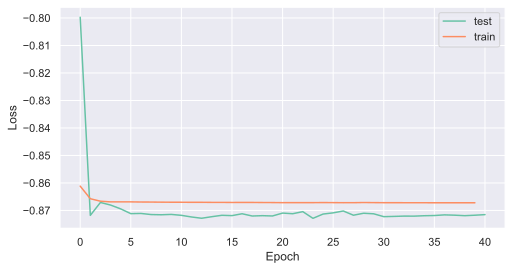

In [45]:
f = plt.figure(figsize=(8, 4))
plt.plot(test_losses, label='test')
plt.plot(train_losses, label='train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

## Визуализация и анализ результатов

In [37]:
#загрузка весов
#dcunet20 = DCUnet20(N_FFT, HOP_LENGTH).to(DEVICE)
#dcunet20.load_state_dict(torch.load('./weights/__weights_Unet20_3.pth', map_location=torch.device('cuda:0')))

Для оценки на сколько пики PPG близки к пикам ECG, вычисляются интервалы между пиками сигналов и затем вычисляется метрика RMSE

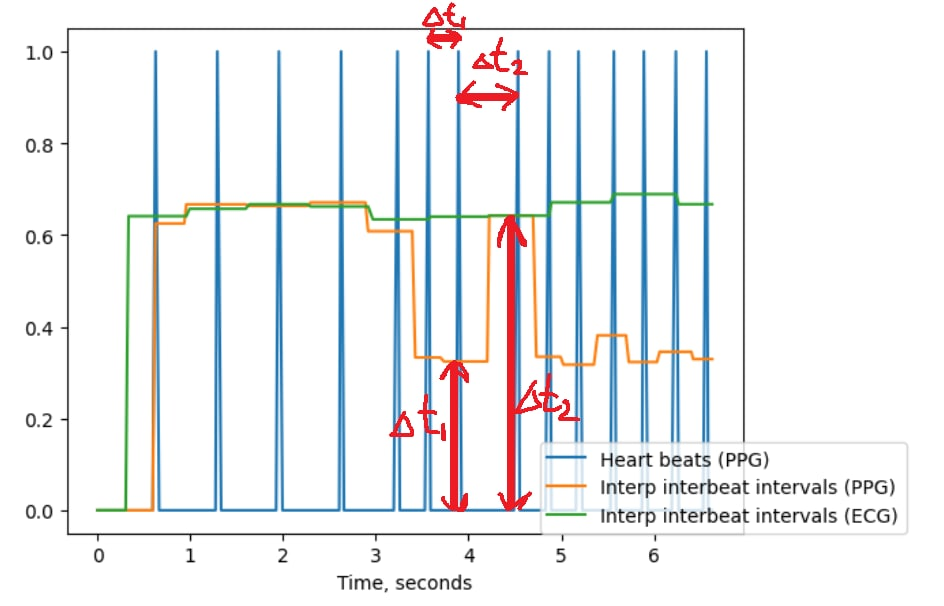

In [6]:
Image("./img/metrics.jpg", width=500)

In [38]:
def format_peaks_to_intervals(ppg_peaks, ts_start, ts_finish):
    timestamps_interp = np.linspace(ts_start, ts_finish, int((ts_finish - ts_start) * SAMPLE_RATE))
    heartbeat_intervals = np.diff(ppg_peaks, prepend=ts_start)
    func = interpolate.interp1d(ppg_peaks, heartbeat_intervals, "nearest", bounds_error=False, fill_value=0)
    heartbeat_intervals_interp = func(timestamps_interp)
    return heartbeat_intervals_interp

In [39]:
def process_exp(ppg_df, distance=None):
    ppg_signal = ppg_df['PPG_signal'].values
    timestamps = ppg_df['Timestamp'].values
    ts_start = timestamps[0]
    ts_finish = timestamps[-1]
    ppg_peaks_idxs = signal.find_peaks(ppg_signal, distance=distance)[0]
    ppg_peaks = timestamps[ppg_peaks_idxs]
    ppg_rr_intervals_interp = format_peaks_to_intervals(ppg_peaks, timestamps[0], timestamps[-1])
    return ppg_rr_intervals_interp

In [37]:
TRAIN_ROOT = './signals/watch_data_train/'
train_ppgs_pathes = glob.glob(f"{TRAIN_ROOT}/PPG_EXP_*.csv")
train_ppgs_pathes.sort()

In [41]:
def Baseline_RMSE(process_exp_fn=process_exp, is_tqdm=False, distance=None):
    all_predictions = []
    all_gt = []
    cycle = tqdm(train_ppgs_pathes) if is_tqdm else train_ppgs_pathes
    for path in cycle:
        ppg_df = pyarrow.csv.read_csv(path).to_pandas()
        ecg_df = pyarrow.csv.read_csv(path.replace("PPG_EXP", "ECG_EXP")).to_pandas()
        ts_st, ts_fn = ppg_df['Timestamp'].values[0], ppg_df['Timestamp'].values[-1]
        ppg_rr_intervals_interp = process_exp_fn(ppg_df, distance)
        ecg_rr_intrvals_interp = format_peaks_to_intervals(ecg_df['ECG_peaks'].values, ts_st, ts_fn)
        all_gt.append(ecg_rr_intrvals_interp)
        all_predictions.append(ppg_rr_intervals_interp)
    all_predictions = np.concatenate(all_predictions)
    all_gt = np.concatenate(all_gt)
    return all_predictions, all_gt, np.sqrt(np.mean((all_gt - all_predictions) ** 2))

In [42]:
all_predictions, all_gt, loss_init = Baseline_RMSE(process_exp, is_tqdm=True, distance=None)
print("Baseline RMSE", "{:.6f}".format(loss_init))

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 25.31it/s]


Baseline RMSE 0.421545


In [43]:
def process_exp_ppg_est(ppg_signal, timestamps, distance=None):
    ppg_peaks_idxs = signal.find_peaks(ppg_signal, distance=distance)[0]
    ppg_peaks = timestamps[ppg_peaks_idxs]
    ppg_rr_intervals_interp = format_peaks_to_intervals(ppg_peaks, timestamps[0], timestamps[-1])
    return ppg_rr_intervals_interp

In [44]:
def DCUnet_RMSE(process_exp_fn=process_exp_ppg_est, is_tqdm=False, distance=None):
    all_predictions = []
    all_gt = []
    cycle = tqdm(train_ppgs_pathes) if is_tqdm else train_ppgs_pathes
    for path in cycle:
        # clear cache
        gc.collect()
        torch.cuda.empty_cache()
        
        ppg_df = pyarrow.csv.read_csv(path).to_pandas()
        ppg_signal = ppg_df.PPG_signal.values
        timestamp = ppg_df['Timestamp'].values
        ts_st, ts_fn = ppg_df['Timestamp'].values[0], ppg_df['Timestamp'].values[-1]
        size = len(timestamp)

        ecg_df = pyarrow.csv.read_csv(path.replace("PPG_EXP", "ECG_EXP")).to_pandas()
        ecg = ecg_df.ECG_peaks.values

        ppg_files = list([path])
        ecg_files = list([path.replace("PPG_EXP", "ECG_EXP")])
        
        train_dataset = SignalsDataset(ppg_files, ecg_files, N_FFT, HOP_LENGTH)
        train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
        
        x_n, x_c = next(iter(train_loader))
        x_est = dcunet20(x_n.to(DEVICE), is_istft=True)
        x = x_est[0].view(-1).detach().cpu().numpy()
        del x_est
        # clear cache
        gc.collect()
        torch.cuda.empty_cache()
        
        temp = x[::-1]
        x = temp[:size]
        x = x[::-1]
        
        ppg_rr_intervals_interp = process_exp_ppg_est(x, timestamp, distance)
        ecg_rr_intrvals_interp = format_peaks_to_intervals(ecg_df['ECG_peaks'].values, ts_st, ts_fn)
        all_gt.append(ecg_rr_intrvals_interp)
        all_predictions.append(ppg_rr_intervals_interp)
    all_predictions = np.concatenate(all_predictions)
    all_gt = np.concatenate(all_gt)
    return all_predictions, all_gt, np.sqrt(np.mean((all_gt - all_predictions) ** 2))

In [45]:
gc.collect()
torch.cuda.empty_cache()
all_predictions, all_gt, loss_init = DCUnet_RMSE(process_exp, is_tqdm=True)
print("DCUnet RMSE", "{:.6f}".format(loss_init))

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:22<00:00,  1.17s/it]

DCUnet RMSE 0.205512


In [38]:
test_ppg_files = sorted(list(TEST_PPG_DIR.rglob('*.csv')))
test_ecg_files = sorted(list(TEST_ECG_DIR.rglob('*.csv')))
test_dataset = SignalsDataset(test_ppg_files, test_ecg_files, N_FFT, HOP_LENGTH)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [38]:
gc.collect()
torch.cuda.empty_cache()
dcunet20.eval()
ppg_n, ecg_c = next(iter(test_loader))
ppg_est = dcunet20(ppg_n.to(DEVICE), is_istft=False)

In [39]:
n = 0
start = 25700
finish = 26000

In [40]:
ppg_est[n] = torch.squeeze(ppg_est[n], 1)
temp = ppg_est[:,:,:,:,0] + ppg_est[:,:,:,:,1] * 1j
ppg_est = temp

In [41]:
ecg_c[n] = torch.squeeze(ecg_c[n], 1)
temp = ecg_c[:,:,:,:,0] + ecg_c[:,:,:,:,1] * 1j
ecg_c = temp

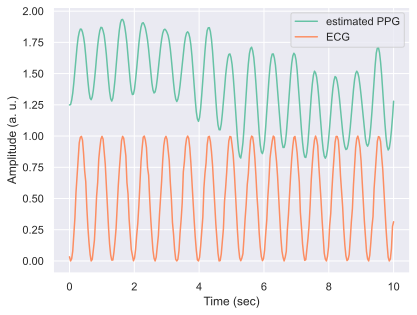

In [51]:
plt.plot(np.linspace(0, 300 / SAMPLE_RATE, 300), -0.5+10*torch.istft(torch.squeeze(ppg_est[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, window = torch.hann_window(N_FFT).cuda(), normalized=True).view(-1).detach().cpu().numpy()[start:finish]);
plt.plot(np.linspace(0, 300 / SAMPLE_RATE, 300), 1*torch.istft(torch.squeeze(ecg_c[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, window = torch.hann_window(N_FFT), normalized=True).view(-1).detach().cpu().numpy()[start:finish]);
plt.legend(['estimated PPG', 'ECG'])
plt.xlabel('Time (sec)');
plt.ylabel('Amplitude (a. u.)');

In [44]:
ppg_n[n].shape
ppg_n[n] = torch.squeeze(ppg_n[n], 1)
temp = ppg_n[:,:,:,:,0] + ppg_n[:,:,:,:,1] * 1j
ppg_n = temp

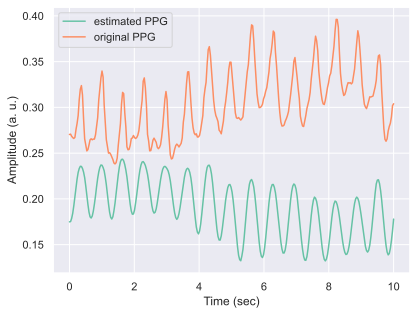

In [53]:
plt.plot(np.linspace(0, 300 / SAMPLE_RATE, 300), torch.istft(torch.squeeze(ppg_est[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, window = torch.hann_window(N_FFT).cuda(), normalized=True).view(-1).detach().cpu().numpy()[start:finish]);
plt.plot(np.linspace(0, 300 / SAMPLE_RATE, 300), -0.6+1*torch.istft(ppg_n[n], n_fft=N_FFT, hop_length=HOP_LENGTH, window = torch.hann_window(N_FFT), normalized=True).view(-1).detach().cpu().numpy()[start:finish])
plt.legend(['estimated PPG', 'original PPG'])
plt.xlabel('Time (sec)');
plt.ylabel('Amplitude (a. u.)');

In [51]:
#del ppg_est
gc.collect()
torch.cuda.empty_cache()

In [55]:
min_dists = np.linspace(0.1, 1., 10) * SAMPLE_RATE
functionals_for_basline = [partial(Baseline_RMSE, distance=thr) for thr in min_dists]
results_for_basline = [fun()[-1] for fun in functionals_for_basline]
functionals_for_DCUnet = [partial(DCUnet_RMSE, distance=thr) for thr in min_dists]
results_for_DCUnet = [fun()[-1] for fun in functionals_for_DCUnet]

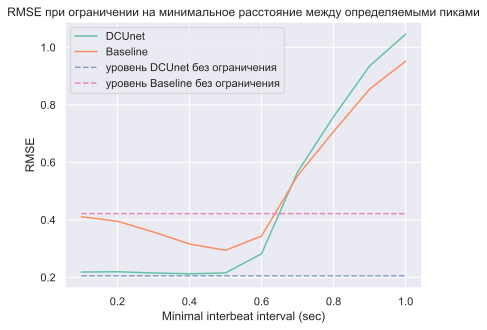

In [56]:
plt.plot(min_dists / SAMPLE_RATE, results_for_DCUnet)
plt.plot(min_dists / SAMPLE_RATE, results_for_basline)
plt.plot(min_dists / SAMPLE_RATE, 0.205512 * np.ones_like(min_dists), '--')
plt.plot(min_dists / SAMPLE_RATE, 0.421545 * np.ones_like(min_dists), '--')
plt.xlabel('Minimal interbeat interval (sec)');
plt.ylabel('RMSE');
plt.title('RMSE при ограничении на минимальное расстояние между определяемыми пиками');
plt.legend(['DCUnet', 'Baseline', 'уровень DCUnet без ограничения', 'уровень Baseline без ограничения']);

Таким образом, из графика можно заключить, что более лучшее значение RMSE у DCUnet достигается не только за счёт отсутствия ложных пиков. А значит и основные пики PPG стали ближе к пикам ECG в результате работы нейронной сети.

In [45]:
estimated_PPG = np.abs(ppg_est[0, 0, :,:].detach().cpu().numpy())
original_PPG = np.abs(ppg_n[0, 0, :,:].detach().cpu().numpy())
ECG = np.abs(ecg_c[0, 0, :,:].detach().cpu().numpy())

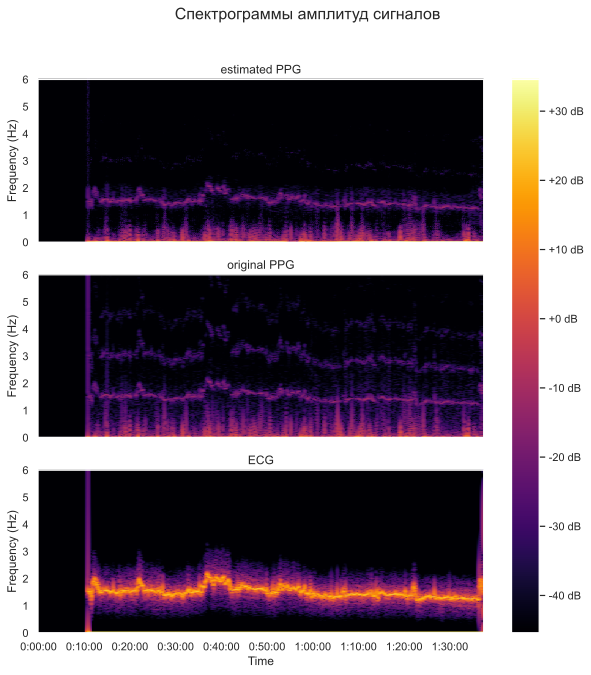

In [46]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 10))


img1 = librosa.display.specshow(librosa.amplitude_to_db(estimated_PPG), 
                         y_axis='linear', x_axis='time', sr=SAMPLE_RATE, hop_length=HOP_LENGTH, cmap='inferno', ax=ax[0])
ax[0].set(title='estimated PPG')

img2 = librosa.display.specshow(librosa.amplitude_to_db(original_PPG), 
                         y_axis='linear', x_axis='time', sr=SAMPLE_RATE, hop_length=HOP_LENGTH, cmap='inferno', ax=ax[1])
ax[1].set(title='original PPG')

img3 = librosa.display.specshow(librosa.amplitude_to_db(ECG), 
                         y_axis='linear', x_axis='time', sr=SAMPLE_RATE, hop_length=HOP_LENGTH, cmap='inferno', ax=ax[2])
ax[2].set(title='ECG')

for ax_i in ax:
    ax_i.label_outer()
    
fig.colorbar(img1, ax=[ax[0], ax[1], ax[2]], format='%+2.0f dB');

ax[0].set(ylim=[0, 6], ylabel='Frequency (Hz)')
ax[1].set(ylim=[0, 6], ylabel='Frequency (Hz)')
ax[2].set(ylim=[0, 6], ylabel='Frequency (Hz)')
fig.suptitle('Спектрограммы амплитуд сигналов', fontsize=16);

Видим, что в результате работы сети стали более выделяется спектральные компоненты на плавающей частоте ECG сигнала.

# Заключение

###  Применена архитектура DCUnet-20 к задаче обработки PPG сигнала для улучшения определения пиков сердцебиения.
### По анализу во временной области отмечено, что PPG сигнал в результате прохождения через нейронную сеть теряет ложные пики и приближается во времени основными пиками к пикам сердцебиения ECG. 
### По анализу спектрограмм сигналов отмечено, что приближение значений пиков PPG сигнала к пикам ECG вызвано способностью спектральной фильтрации архитектурой нейронной сети.
